In [2]:
#Uploading cell_count matrix and making an anndata file

import pandas as pd
import scanpy as sc
table = pd.read_csv('/media/anastasiasinger/Elements SE/xenium_5k_854.csv', sep = ',')
import anndata as ad
gene = "Epcam"

counts = table.groupby(['cell_id', 'feature_name']).size().unstack(fill_value=0)
adata_slice = ad.AnnData(
    X=counts.values,
    obs=pd.DataFrame(index=counts.index),
    var=pd.DataFrame(index=counts.columns)
)
gene_cells_slice = adata_slice[adata_slice[:, gene].X > 0] 

In [4]:
gene_cells_slice.write('854_Epcam_cells.h5ad')

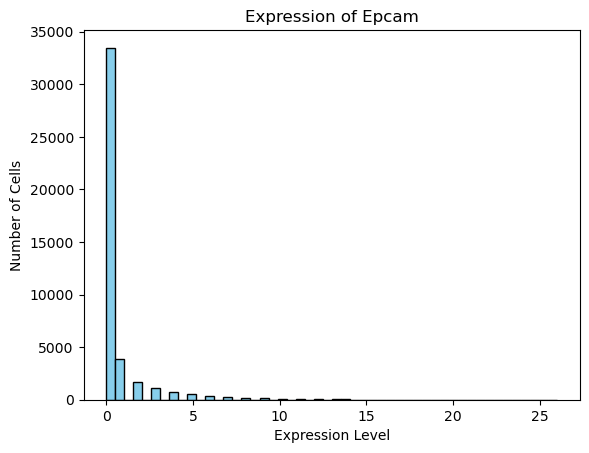

In [12]:
#Epcam expression distribution

import matplotlib.pyplot as plt
gene_expr = adata_slice[:, gene].X.toarray().flatten() if hasattr(adata_slice[:, gene].X, "toarray") else adata_slice[:, gene].X.flatten()

# Plot histogram
plt.hist(gene_expr, bins=50, color='skyblue', edgecolor='black')
plt.title(f'Expression of {gene}')
plt.xlabel('Expression Level')
plt.ylabel('Number of Cells')
plt.show()

In [4]:
#Preprocessing

import numpy as np
import os
import random

os.environ["IGRAPH_SEED"] = "42"
np.random.seed(42)
random.seed(42)


sc.pp.normalize_total(gene_cells_slice, target_sum=1e4)
sc.pp.log1p(gene_cells_slice)

gene_cells_slice.raw = gene_cells_slice.copy()

sc.pp.highly_variable_genes(gene_cells_slice, n_top_genes=2750, subset=True) #better 2750

sc.pp.scale(gene_cells_slice)
sc.tl.pca(gene_cells_slice, n_comps=30, random_state=42)


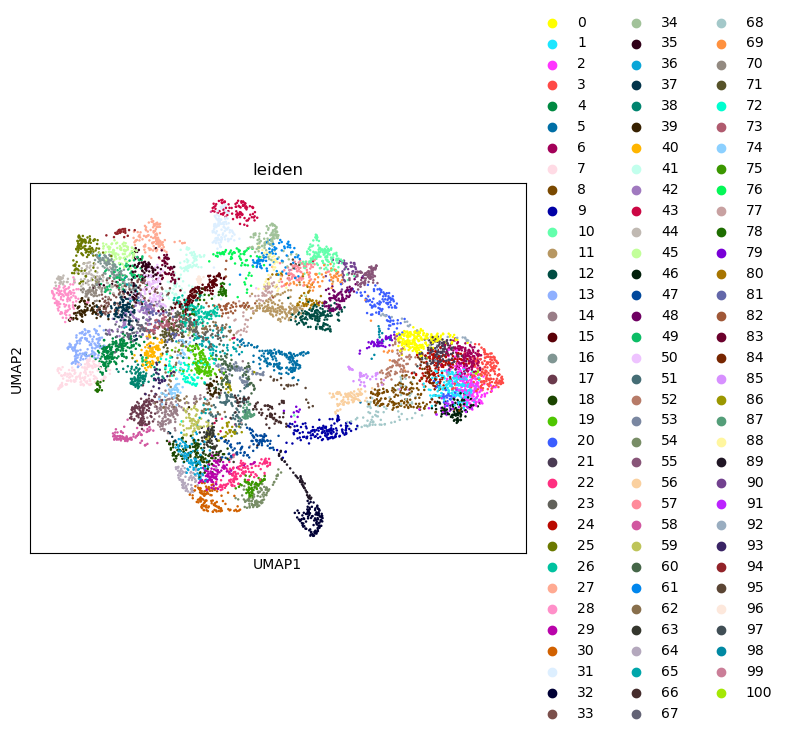

In [35]:
#Leiden clustering 

sc.pp.neighbors(gene_cells_slice, n_neighbors=5, n_pcs=30, random_state=42)

sc.tl.leiden(gene_cells_slice, resolution=5, random_state=42)  # adjust resolution for more/fewer clusters
sc.tl.umap(gene_cells_slice, key_added = 'umap', random_state=42, min_dist=0.4)
sc.pl.umap(gene_cells_slice, color=["leiden"])
gene_cells_slice.write("854_clustering_results_res5_scdeed.h5ad")

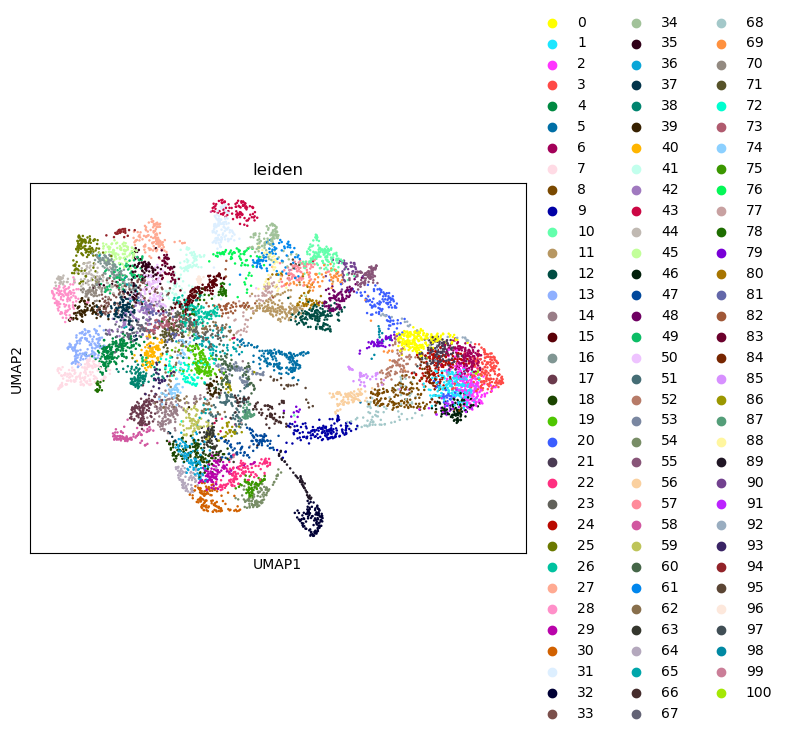

In [20]:
import scanpy as sc
gene_cells_slice = sc.read_h5ad("854_clustering_results_res5_scdeed.h5ad")
sc.pl.umap(gene_cells_slice, color=["leiden"])


In [ ]:
#Cell annotation 

sc.tl.rank_genes_groups(
    gene_cells_slice, groupby='leiden', method="wilcoxon", use_raw=gene_cells_slice.raw)

In [ ]:
#Dictionary with placodal markers for the manual cell annotation

placode_markers = {
    "Adenohypophyseal placode": [
        "Hesx1", "Isl1",
        "Nkx2-2", "Pitx2", "Lhx4", "Six6", "Otx2", "Pitx1"
    ],
    "Lens placode": [
        "Tfap2b", "Maf", 
        "Pax3", "Pax6", "Six6", "Foxg1", "Eya1", "Dlx3"
    ],
    "Trigeminal placode": [
        "Neurog1", "Isl1", "Pax3", "Fgfr4"
    ],
    "Epibranchial placode": [
        "Foxi2", "Hoxb5", "Myb",
        "Phox2a", "Sox3", 'Neurog2'
    ],
    "Olfactory placode": [
       "Hes5",
        "Nr2e1", "Gad2", "Vax1", "Nr2e1", "Foxg1"
    ],
    "Otic placode": [
        "Gbx2", "Hey2", "Gata2",
        "Hmx3", "Lmx1a",
        "Pax8", "Sox10", "Tbx1"
    ]
}

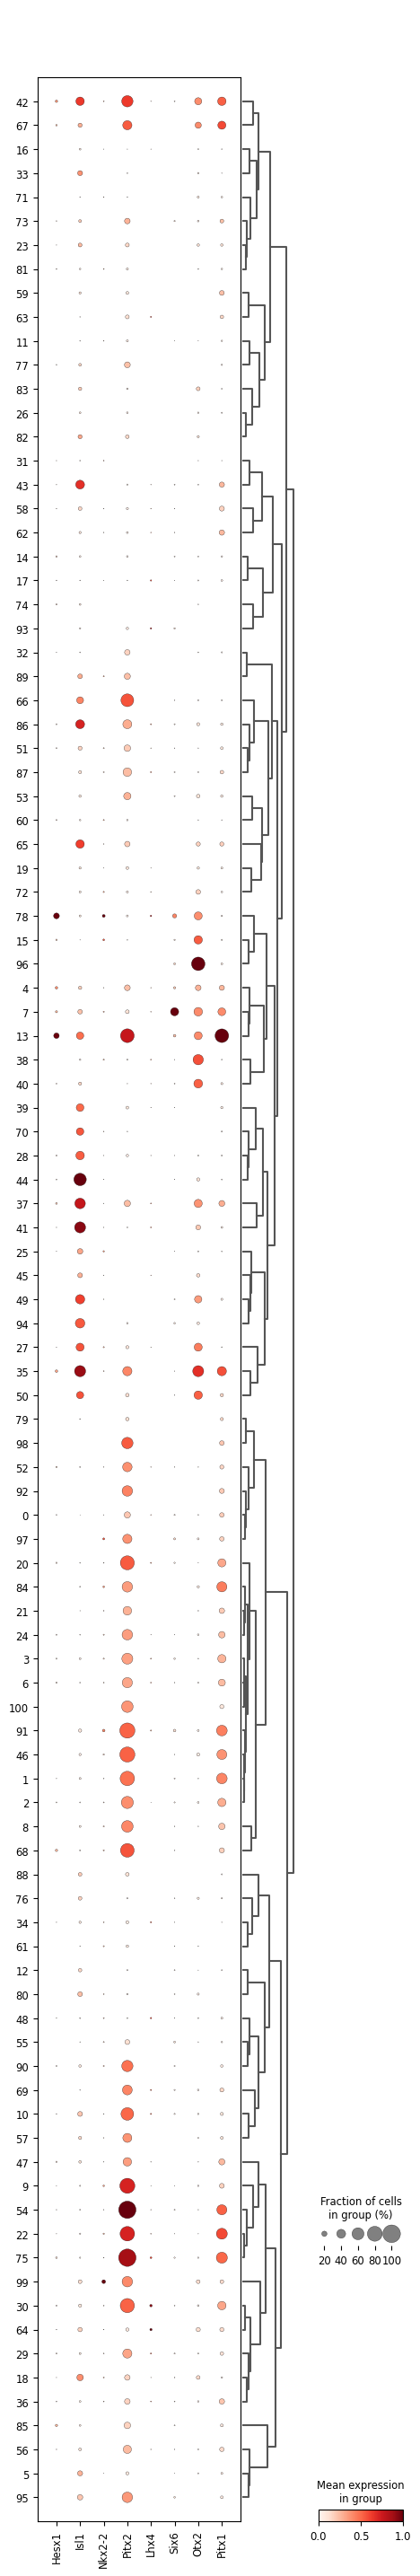

In [59]:
#'Adenohypophyseal placode': ['13']
sc.pl.rank_genes_groups_dotplot(
    gene_cells_slice, groupby='leiden', standard_scale="var", var_names=placode_markers["Adenohypophyseal placode"])

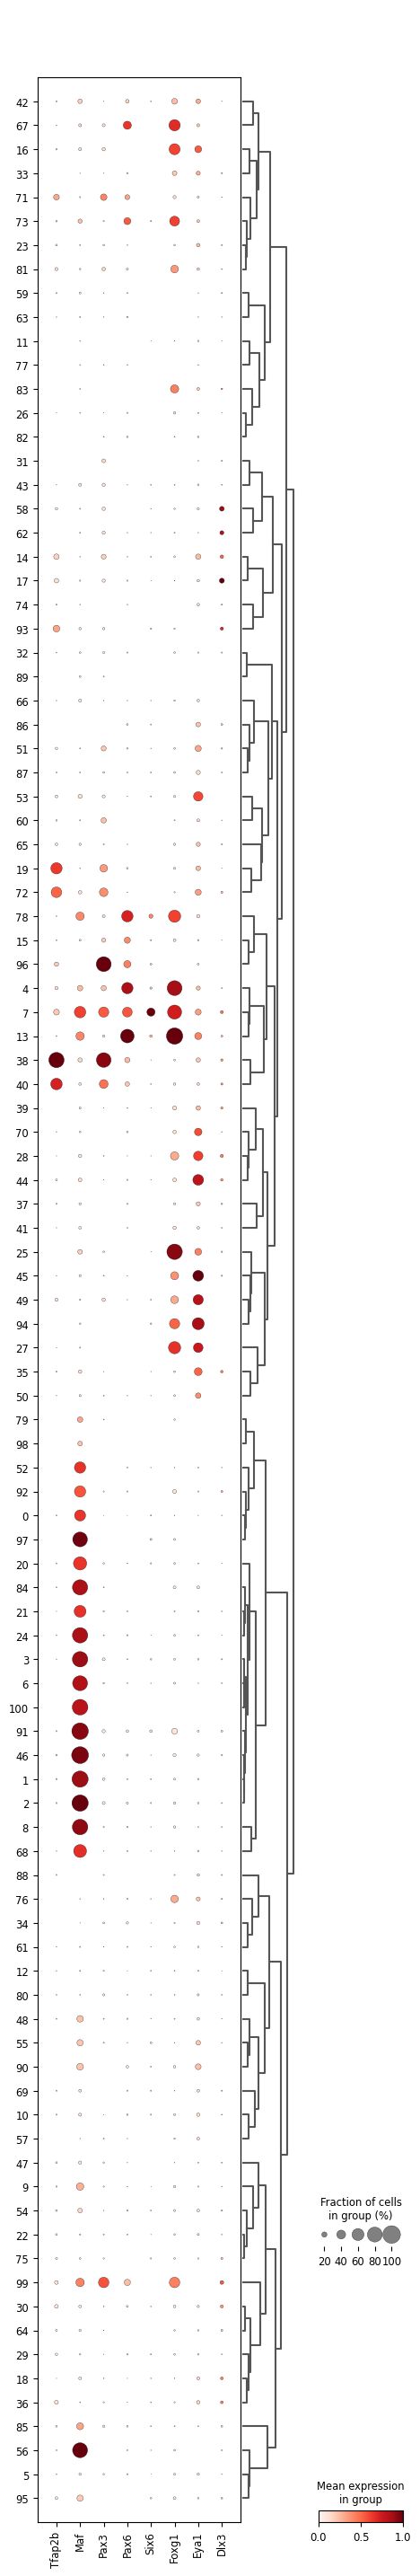

In [9]:
# Lens placode = - 
sc.pl.rank_genes_groups_dotplot(
    gene_cells_slice, groupby='leiden', standard_scale="var", var_names=placode_markers["Lens placode"])

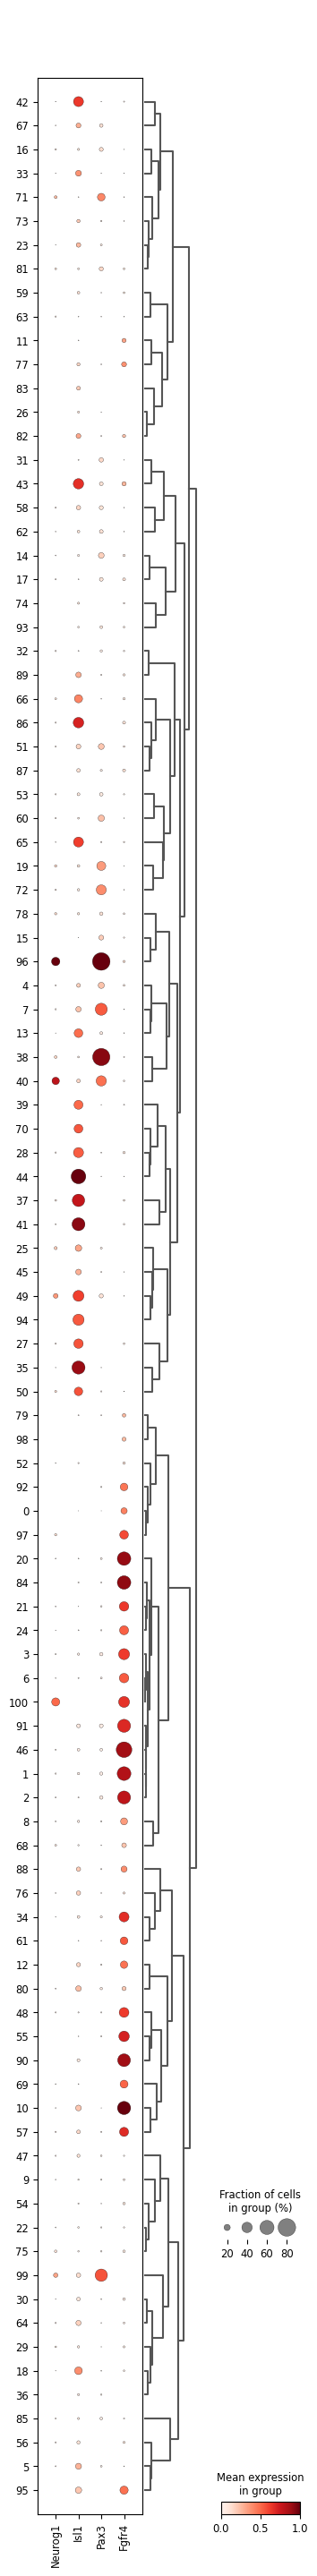

In [11]:
#'Trigeminal placode': ['40', '38']
sc.pl.rank_genes_groups_dotplot(
    gene_cells_slice, groupby='leiden', standard_scale="var", var_names=placode_markers["Trigeminal placode"])

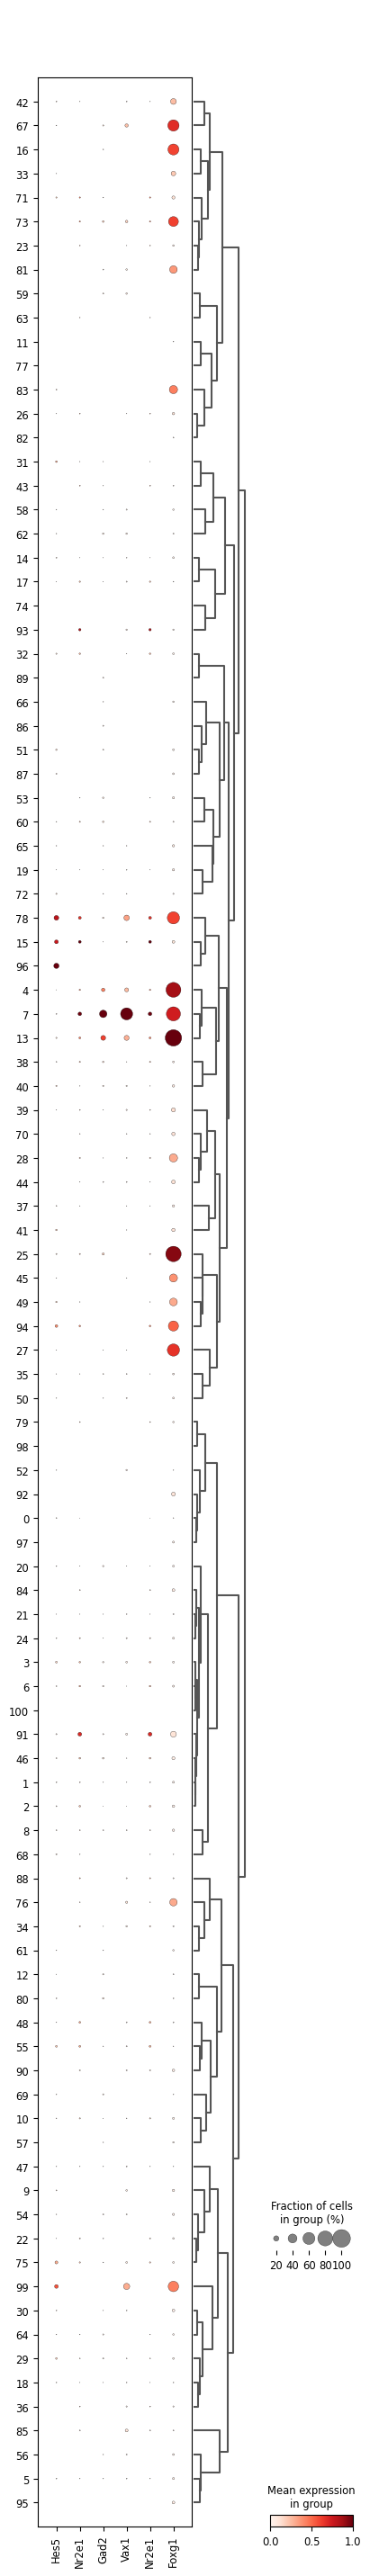

In [27]:
#'Olfactory placode': ['7', '4']
sc.pl.rank_genes_groups_dotplot(
    gene_cells_slice, groupby='leiden', standard_scale="var", var_names=placode_markers["Olfactory placode"])

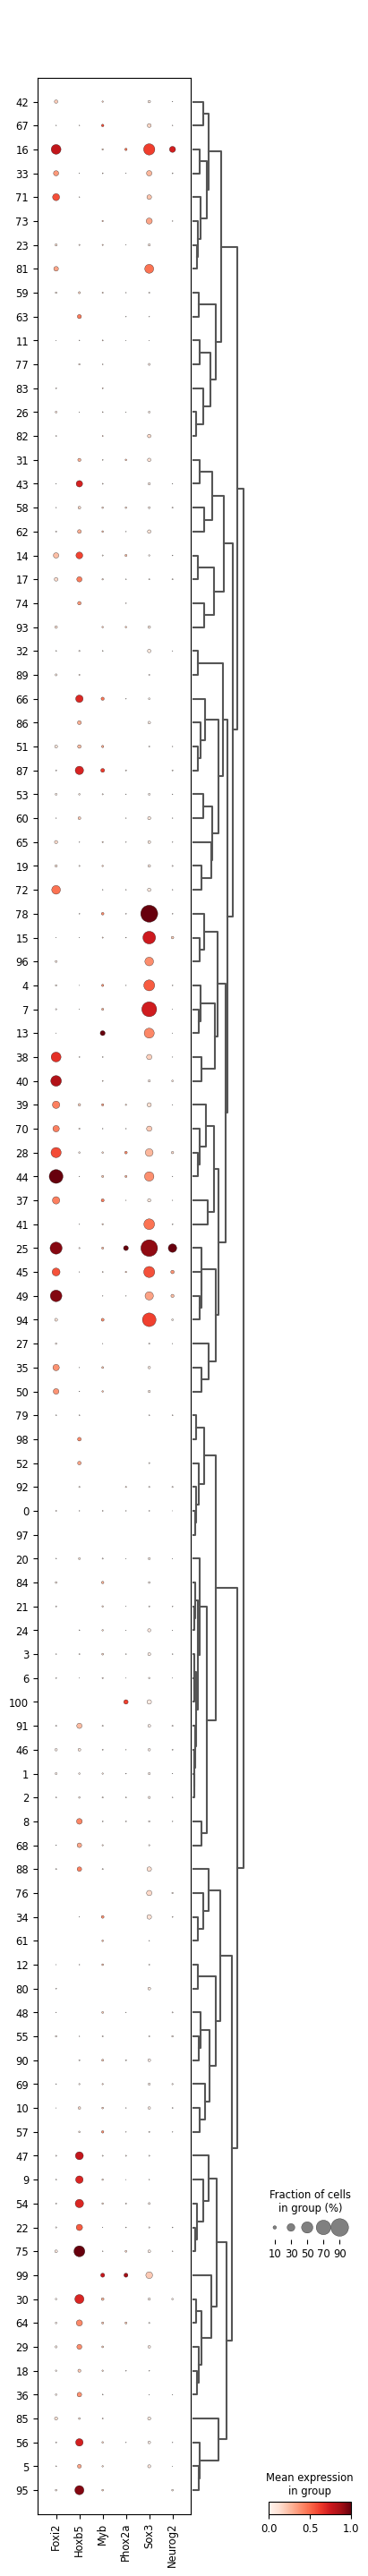

In [25]:
#'Epibranchial placode': ['25', '45']
sc.pl.rank_genes_groups_dotplot(
    gene_cells_slice, groupby='leiden', standard_scale="var", var_names=placode_markers["Epibranchial placode"])

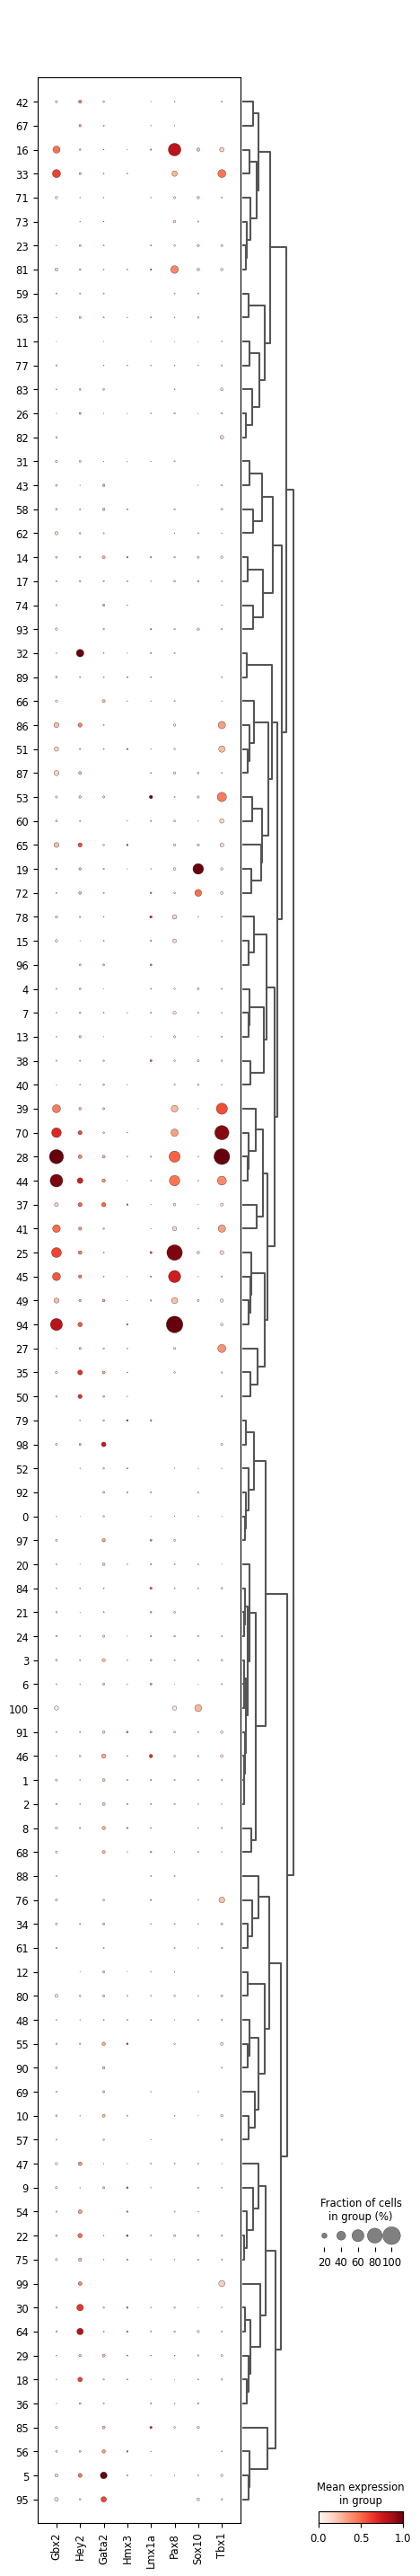

In [35]:
# 'Otic placode': ['70', '28']
sc.pl.rank_genes_groups_dotplot(
    gene_cells_slice, groupby='leiden', standard_scale="var", var_names=placode_markers["Otic placode"])

In [22]:
# Let's annotate clusters

def annotate_leiden_clusters(adata, cluster_mapping, leiden_key='leiden', new_key='cluster_name'):
    import pandas as pd
    adata_copy = adata.copy()
    # Ensure leiden column is string
    adata_copy.obs[leiden_key] = adata_copy.obs[leiden_key].astype(str)

    # Build reverse mapping: cluster ID (string) → name
    cluster_to_name = {
        str(cluster): name
        for name, clusters in cluster_mapping.items()
        for cluster in clusters
    }

    # Apply mapping; fall back to original leiden ID if not in map
    adata_copy.obs[new_key] = adata_copy.obs[leiden_key].map(cluster_to_name)
    adata_copy.obs[new_key] = adata_copy.obs[new_key].fillna('other')

    # Convert to category
    adata_copy.obs[new_key] = adata_copy.obs[new_key].astype('category')
    return adata_copy



In [26]:
cluster_map = {
    'Epibranchial placode': ['25', '45'],
    'Trigeminal placode': ['40', '38'],
    'Olfactory placode': ['7', '4'],
    'Adenohypophyseal placode': ['13'], 
    'Otic placode': ['70', '28']
}

adata_named = annotate_leiden_clusters(gene_cells_slice, cluster_map)

mapped_cluster_names = list(cluster_map.keys())

print(adata_named.obs['cluster_name'].unique())


['other', 'Trigeminal placode', 'Epibranchial placode', 'Adenohypophyseal placode', 'Olfactory placode', 'Otic placode']
Categories (6, object): ['Adenohypophyseal placode', 'Epibranchial placode', 'Olfactory placode', 'Otic placode', 'Trigeminal placode', 'other']


In [28]:
adata_clust = adata_named[adata_named.obs['cluster_name'] != 'other']

In [30]:
sc.tl.rank_genes_groups(
    adata_clust, groupby='cluster_name', method="wilcoxon")

/home/anastasiasinger/anaconda3/lib/python3.12/site-packages/anndata/_core/anndata.py:1138: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


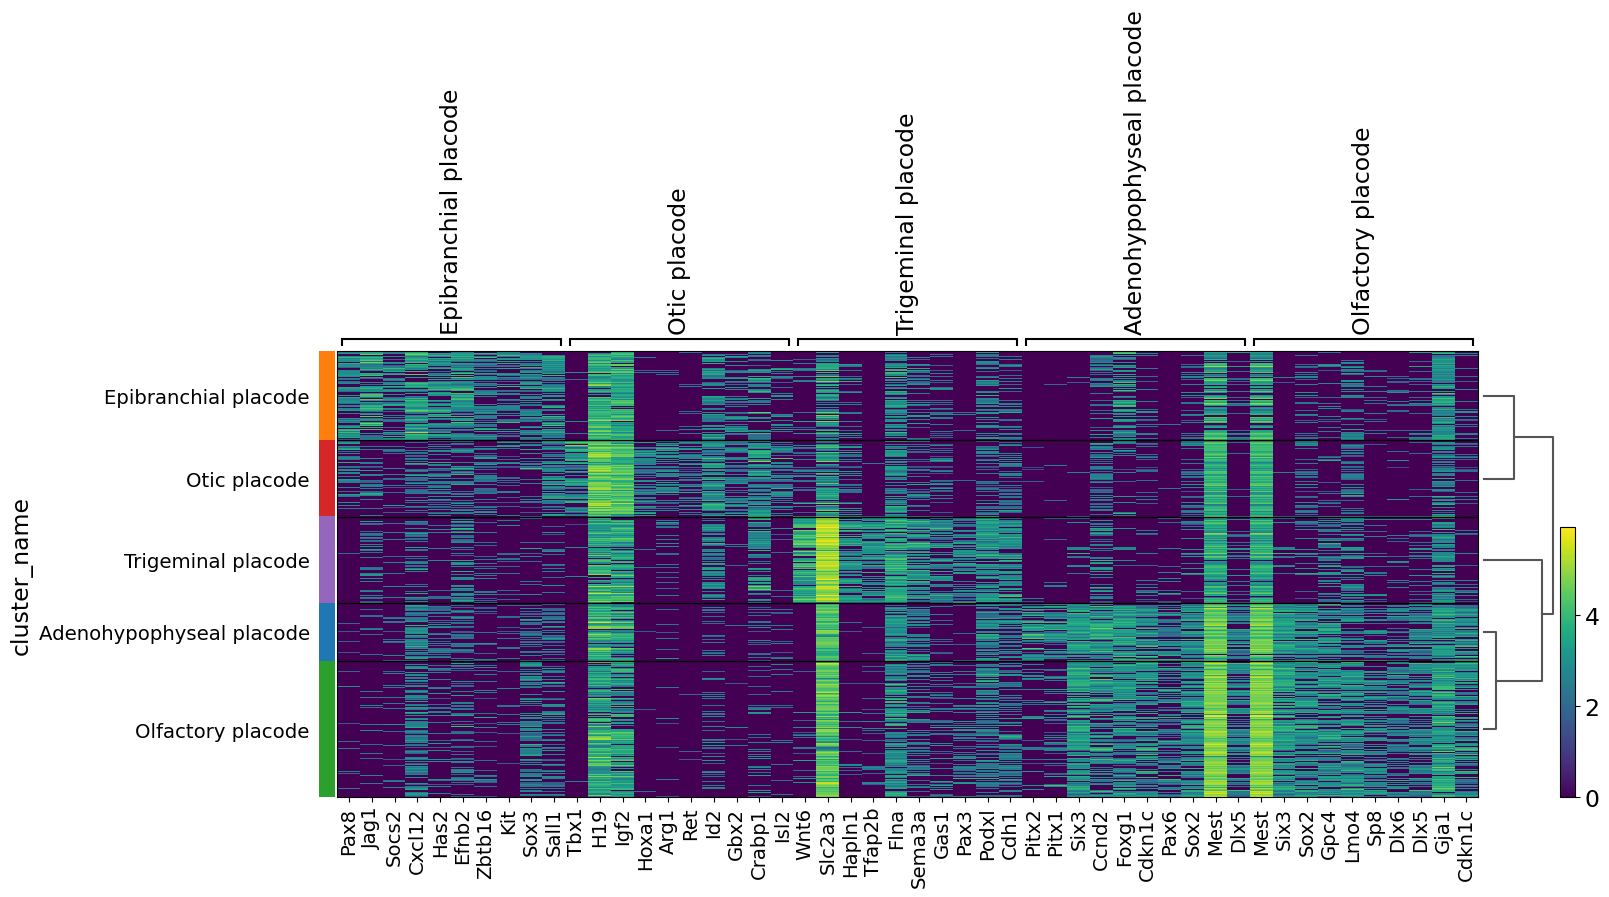

In [32]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 17})
sc.pl.rank_genes_groups_heatmap(adata_clust, n_genes=10, show_gene_labels=True, save='heatmap_854.png')

In [8]:
#setting palette 

palette_placodes = {
    'Adenohypophyseal placode': "#1f78b4",
    'Epibranchial placode': "#ff7f00",
    'Lens placode': "#33a02c",
    'Olfactory placode': "#e31a1c",
    'Otic placode': "#6a3d9a",
    'Trigeminal placode': "#b15928",
    'other': "#bdbdbd" 
}

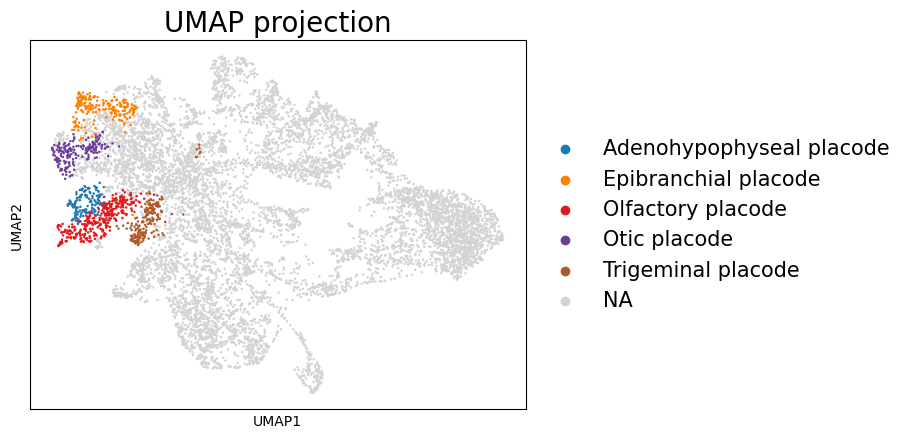

In [10]:
import matplotlib as mpl
mpl.rcParams['axes.titlesize'] = 20  # default title fontsize
sc.pl.umap(adata_named, color=['cluster_name'], groups=['Trigeminal placode', 'Epibranchial placode', 'Adenohypophyseal placode', 'Lens placode', 'Olfactory placode', 'Otic placode'], title='UMAP projection', legend_fontsize=15, save="UMAP_Embed_854.png", palette=palette_placodes)

In [16]:
#Fetching spatial information

import numpy as np
import pandas as pd
cells_clust = pd.read_csv('/media/anastasiasinger/Elements SE/xenium_5k_1/xenium_5k_8_9_5/20250228__153209__KA-789/xenum_1/output-XETG00372__0051519__854__20250228__153611/cells.csv', sep = ',')
cells_clust = cells_clust[['cell_id', 'x_centroid', 'y_centroid']]
print(cells_clust.head())

cells_clust = cells_clust[cells_clust['cell_id'].isin(pd.DataFrame(gene_cells_slice.obs).index)]

df_clusters = gene_cells_slice.obs[['leiden']].copy()
df_clusters = df_clusters.reset_index().rename(columns={'index': 'cell_id'})

df_clusters = pd.merge(cells_clust, df_clusters, on='cell_id', how='inner')
colors_clusters = gene_cells_slice.uns['leiden_colors']
colors = pd.DataFrame({
    'leiden': np.linspace(0, len(colors_clusters)-1, len(colors_clusters), dtype=int),
    'color': colors_clusters})
print(colors.head())
print(df_clusters)

      cell_id  x_centroid  y_centroid
0  aaaanlhi-1  922.941772  416.044220
1  aaabbhoc-1  884.618042  454.441650
2  aaafcmog-1  885.581421  447.646271
3  aaaimhbe-1  871.007935  500.071045
4  aaaimphd-1  877.730957  524.944580
   leiden    color
0       0  #ffff00
1       1  #1ce6ff
2       2  #ff34ff
3       3  #ff4a46
4       4  #008941
         cell_id   x_centroid   y_centroid leiden
0     aabgecej-1   869.125610   478.477325     15
1     aabjniio-1  1091.953003   600.032471     33
2     aabmigac-1  1083.539551   594.007751     49
3     aabnakop-1  1076.162964   593.277588     49
4     aacobcga-1  1037.376099   387.845245     19
...          ...          ...          ...    ...
9293  oiahgbhb-1  2600.958740  2496.861572     88
9294  oiahlhkl-1  2589.193848  2515.874023     88
9295  oialpfff-1  2589.440918  2499.625488     82
9296  oiapebkg-1  2580.147461  2512.491943     82
9297  oibinehb-1  2883.191406  2054.501465     67

[9298 rows x 4 columns]


In [18]:
df_clusters['cluster']=df_clusters['cell_id'].map(adata_named.obs['cluster_name'])

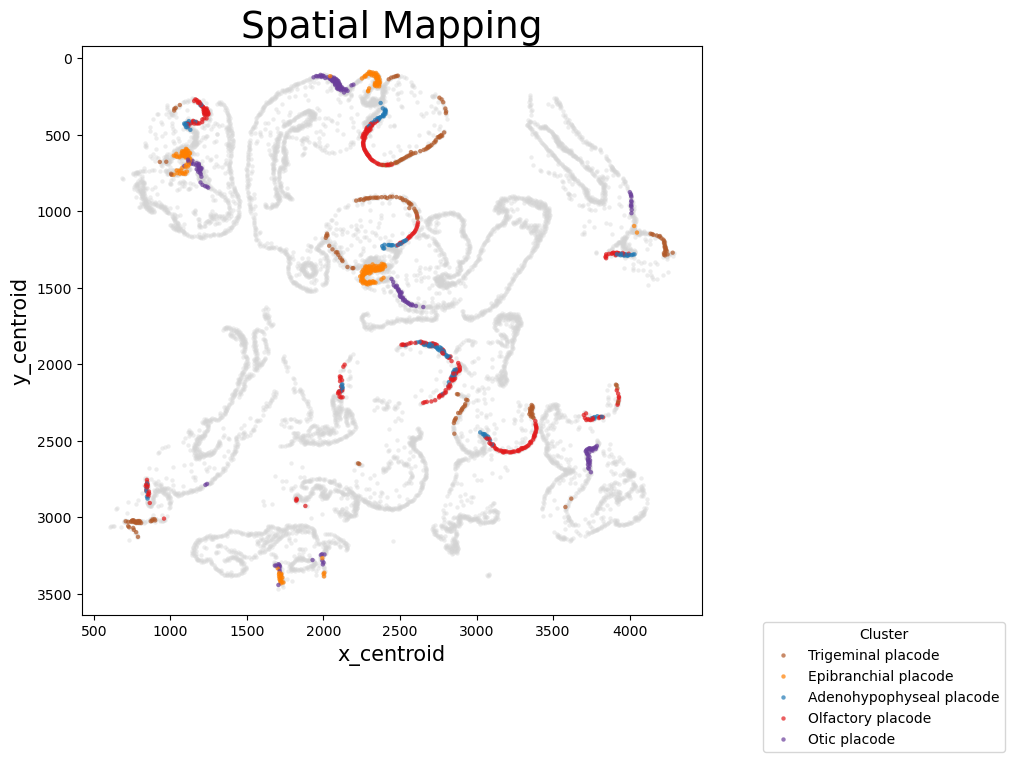

In [20]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Ensure 'leiden' columns are strings
df_clusters['cluster'] = df_clusters['cluster'].astype(str)
placode_palette = {
    'Adenohypophyseal placode': "#1f78b4",
    'Epibranchial placode': "#ff7f00",
    'Lens placode': "#33a02c",
    'Olfactory placode': "#e31a1c",
    'Otic placode': "#6a3d9a",
    'Trigeminal placode': "#b15928",
    'other': "#bdbdbd" 
}
selected_clusters = ['Adenohypophyseal placode', 'Otic placode', 'Trigeminal placode', 'Epibranchial placode', 'Olfactory placode']
# Filter the clusters
df_filtered = df_clusters[df_clusters['cluster'].isin(selected_clusters)]

# Create the palette only for selected clusters

# Plot
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
#background scatterplot 
sns.scatterplot(
    data=df_clusters,
    x='x_centroid',
    y='y_centroid',
    s=10,
    color='#d3d3d3',
    linewidth=0,
    alpha=0.4
)

#main_scatterplot
sns.scatterplot(
    data=df_filtered,
    x='x_centroid',
    y='y_centroid',
    hue='cluster',
    palette=placode_palette,
    s=10,
    linewidth=0,
    alpha=0.7
)
ax.invert_yaxis()
plt.gca().set_aspect('equal')
plt.title('Spatial Mapping', fontsize=27)
plt.xlabel('x_centroid', fontsize=15)
plt.ylabel('y_centroid', fontsize=15)
plt.legend(title='Cluster', bbox_to_anchor=(1.5,0))
plt.savefig('854_clusters.png')
plt.show()

In [87]:
import pandas as pd
adata_named.obs['cell_id']=adata_named.obs_names
clusters_res5 = pd.DataFrame(adata_named.obs[['cell_id', 'cluster_name']])
clusters_res5 = clusters_res5.rename(columns={'cluster_name': 'group'})
clusters_res5.to_csv('854_Epcam_clusters_final.csv', index=False)
